<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Trabajo Final de Estudios</header1></center>
<center><h1>Predicción de la evolución de criptomonedas en Binance mediante IA</header1></center>
<center><h1>Modelo de regresión</header1></center>

Trabajo fin de estudio presentado por: **Jorge Manuel Ibáñez Vázquez** <br>
Tipo de trabajo:                       Piloto experimental <br>
Director:                              Luis Guadalupe Macías Trejo <br>
Fecha:                                 17/04/2025

## Resumen
Este modelo se centró en la predicción del valor exacto del precio de BTC con una granularidad horaria.
- Fuentes de Datos: Los datos se obtuvieron directamente de la API de Binance para el par BTCUSDT con un intervalo de 1 hora (Client.KLINE_INTERVAL_1HOUR). Se implementó una lógica para cargar datos desde un archivo CSV (btc_hour_dataset_regresion.csv) si estaba disponible, o para descargar datos históricos y actualizarlos desde el 1 de enero de 2025 hasta la fecha actual.



## Importación de librerias necesarias

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib
from binance.client import Client
import os
import warnings
from sklearn.preprocessing import RobustScaler # Importar RobustScaler


## Cargar\Descargar los valores a comparar: BTC/USD

### Hay que eliminar los multi-índices para trabajar con los dataframes de forma correcta

In [5]:
def simplificar_multiindice(df, nombre_indice_fecha='Date'):
    # Paso 1: Eliminar el nivel 'Ticker' del MultiIndex de columnas
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel('Ticker')
    
    # Paso 2: Eliminar el nombre del nivel de columnas
    df.columns.name = None
    
    # Paso 3: Renombrar el índice de fechas
    if 'Price' in df.columns:
        df['Price'] = pd.to_datetime(df['Price'])  # Asegurarse de que 'date' esté en formato datetime
        df = df.set_index('Price')
        df.index.name = nombre_indice_fecha
    elif 'Date' not in df.columns:
        df.index.name = nombre_indice_fecha
    return df

### Descargar datos del BTC/USD

In [6]:
# --- MIS CLAVES API DE BINANCE ---
API_KEY = '2POZsiboHQwbAIH4RcMxNu2ZSSxNC2eSG1rEDIbQNIrGDZ6EVkxFwa04oFfs3ACw'
API_SECRET = 'YJGcEy8XPyzsVjKH2GrGCRmxRp2Gg0klvJNwtPO8e4Mjl3SleXyKHLmwCiUi1aRW'
# ---------------------------------

# Inicializar el cliente de Binance
client = Client(API_KEY, API_SECRET)

# Función para simplificar el multiíndice (mantenemos la versión genérica que es más segura)
def simplificar_multiindice(df):
    """
    Simplifica el MultiIndex de columnas si existe, dejando solo el último nivel.
    Esta función es más robusta y no asume nombres específicos de niveles.
    """
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(-1)
        df.columns.name = None
    return df

csv_file_name = "btc_hour_dataset_regresion.csv"  # Nombre del archivo CSV
symbol = "BTCUSDT" # El símbolo para BTC/USD en Binance es BTCUSDT
interval_binance = Client.KLINE_INTERVAL_1HOUR # Intervalo de 1 hora para Binance API

# Fecha de inicio para los datos a añadir (desde 2025-01-01)
start_date_to_add = datetime(2025, 1, 1)
# Fecha de fin: hoy
end_date_current = datetime.now()

#start_date_download = start_date_download.replace(tzinfo=None)
#end_date_current = end_date_current.replace(tzinfo=None)

# Inicializar un DataFrame vacío para los datos existentes o nuevos
data_BTC_hour = pd.DataFrame()
start_date_download = start_date_to_add # Por defecto, la fecha de inicio de descarga

try:
    # Intentar cargar desde CSV
    # Al cargar, asumimos que 'Date' es la columna de índice
    data_BTC_hour = pd.read_csv(csv_file_name, index_col='Date', parse_dates=True)
    print("✅ Datos cargados desde CSV.")

    # Asegurar que 'Close' sea numérica y eliminar NaNs
    data_BTC_hour['Close'] = pd.to_numeric(data_BTC_hour['Close'], errors='coerce')
    data_BTC_hour = data_BTC_hour.dropna(subset=['Close'])

    # Determinar la última fecha existente en el CSV
    last_date_in_csv = data_BTC_hour.index.max()
    print(f"Última fecha en el CSV: {last_date_in_csv}")

    # Si la última fecha en el CSV es anterior a la fecha actual,
    # ajustamos la fecha de inicio de descarga para que comience después.
    if last_date_in_csv and last_date_in_csv < end_date_current:
        # Añadir una hora al último timestamp para evitar duplicados si el intervalo es horario
        start_date_download = last_date_in_csv + timedelta(hours=1)
        # Asegurarse de que no descargue datos anteriores a 2025-01-01 si el CSV ya está actualizado hasta antes
        if start_date_download < start_date_to_add:
            start_date_download = start_date_to_add
    else:
        # Si el CSV ya está completamente actualizado o no hay datos,
        # la descarga comenzará desde start_date_to_add.
        start_date_download = start_date_to_add

    print(f"Comenzando descarga desde: {start_date_download.strftime('%Y-%m-%d %H:%M:%S')} (después de la última fecha en CSV o desde 2025-01-01).")

except FileNotFoundError:
    print(f"⚠️ El archivo '{csv_file_name}' no se encontró. Se descargará todo desde {start_date_to_add.date()}.")
    start_date_download = start_date_to_add
except Exception as e:
    print(f"⚠️ Error al cargar CSV: {e}")
    print(f"⬇️ Se intentará descargar todo desde {start_date_to_add.date()} debido al error.")
    start_date_download = start_date_to_add


# Descargar datos desde la fecha de inicio calculada hasta la fecha actual de Binance
if start_date_download < end_date_current:
    print(f"Descargando datos adicionales de Binance desde {start_date_download.date()} hasta {end_date_current.date()}...")

    # Binance API tiene un límite de 1000 klines por llamada.
    # Iteramos en bloques hasta alcanzar la fecha de fin.
    current_start_timestamp = int(start_date_download.timestamp() * 1000) # Convertir a milisegundos para Binance
    end_timestamp = int(end_date_current.timestamp() * 1000)

    all_klines = []
    # Límite de 1000 para el número de klines
    limit = 1000

    while current_start_timestamp < end_timestamp:
        print(f"Descargando bloque desde: {datetime.fromtimestamp(current_start_timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')}")
        try:
            klines = client.get_historical_klines(
                symbol,
                interval_binance,
                str(current_start_timestamp), # Start time en milisegundos como string
                # str(min(current_start_timestamp + (limit * 3600 * 1000), end_timestamp)) # Cálculo de fin
                # La API de Binance puede manejar un 'endTime' o simplemente la cantidad 'limit'
                # Si no se especifica 'endTime', devuelve 'limit' desde 'startTime'
            )
            if not klines:
                break # No hay más datos
            all_klines.extend(klines)
            # Actualizar el current_start_timestamp al timestamp del último kline + 1 hora
            # El kline[0] es el Open time en milisegundos
            current_start_timestamp = klines[-1][0] + (1 * 3600 * 1000) # Sumar una hora en milisegundos

            # Si el último kline descargado es el final de nuestro rango, salir del bucle
            if klines[-1][0] >= end_timestamp:
                break

        except Exception as e:
            print(f"Error al descargar bloque de datos de Binance: {e}")
            break # Salir del bucle en caso de error grave

    if all_klines:
        # Convertir los klines a un DataFrame
        new_data = pd.DataFrame(all_klines, columns=[
            'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
            'Close time', 'Quote asset volume', 'Number of trades',
            'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'
        ])

        # Convertir 'Open time' a datetime y establecerlo como índice
        new_data['Open time'] = pd.to_datetime(new_data['Open time'], unit='ms')
        new_data = new_data.set_index('Open time')
        new_data.index.name = 'Date' # Renombrar el índice a 'Date'

        # Convertir las columnas numéricas a float
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in numeric_cols:
            new_data[col] = pd.to_numeric(new_data[col], errors='coerce')

        # Mantener solo las columnas deseadas y reordenarlas
        columns_to_keep_final = ['Close', 'High', 'Low', 'Open', 'Volume']
        new_data = new_data[columns_to_keep_final]

        # Concatenar los datos existentes con los nuevos
        if data_BTC_hour.empty:
            data_BTC_hour = new_data
        else:
            data_BTC_hour = pd.concat([data_BTC_hour, new_data])
            # Eliminar duplicados después de la concatenación
            data_BTC_hour = data_BTC_hour[~data_BTC_hour.index.duplicated(keep='first')]
            # Forzar conversión del índice a datetime
            data_BTC_hour.index = pd.to_datetime(data_BTC_hour.index, errors='coerce')
            # Ordenar por índice (fecha)
            data_BTC_hour = data_BTC_hour.sort_index()

        # Guardar el DataFrame actualizado en el CSV
        # Aseguramos que 'Date' (el índice) se guarde como columna
        data_BTC_hour.to_csv(csv_file_name, index=True)
        print(f"✅ Datos descargados de Binance y actualizados en {csv_file_name}")
    else:
        print("No se descargaron nuevos datos de Binance o no hay datos disponibles en el rango especificado.")
else:
    print("El CSV ya está actualizado hasta la fecha solicitada o no hay nuevos datos que añadir desde Binance.")

# Mostrar primeras filas del DataFrame final
print("\nPrimeras filas del DataFrame final:")
print(data_BTC_hour.head())

# Mostrar últimas filas del DataFrame final
print("\nÚltimas filas del DataFrame final:")
print(data_BTC_hour.tail())

✅ Datos cargados desde CSV.
Última fecha en el CSV: 2025-06-19 19:00:00
Comenzando descarga desde: 2025-06-19 20:00:00 (después de la última fecha en CSV o desde 2025-01-01).
Descargando datos adicionales de Binance desde 2025-06-19 hasta 2025-06-28...
Descargando bloque desde: 2025-06-19 22:00:00
✅ Datos descargados de Binance y actualizados en btc_hour_dataset_regresion.csv

Primeras filas del DataFrame final:
                        Close      High       Low      Open     Volume
Date                                                                  
2024-12-31 23:00:00  93576.00  93756.00  93375.38  93488.83  336.57995
2025-01-01 00:00:00  94401.14  94509.42  93489.03  93576.00  755.99010
2025-01-01 01:00:00  93607.74  94408.72  93578.77  94401.13  586.53456
2025-01-01 02:00:00  94098.91  94105.12  93594.56  93607.74  276.78045
2025-01-01 03:00:00  93838.04  94098.91  93728.22  94098.90  220.99302

Últimas filas del DataFrame final:
                         Close       High        Lo

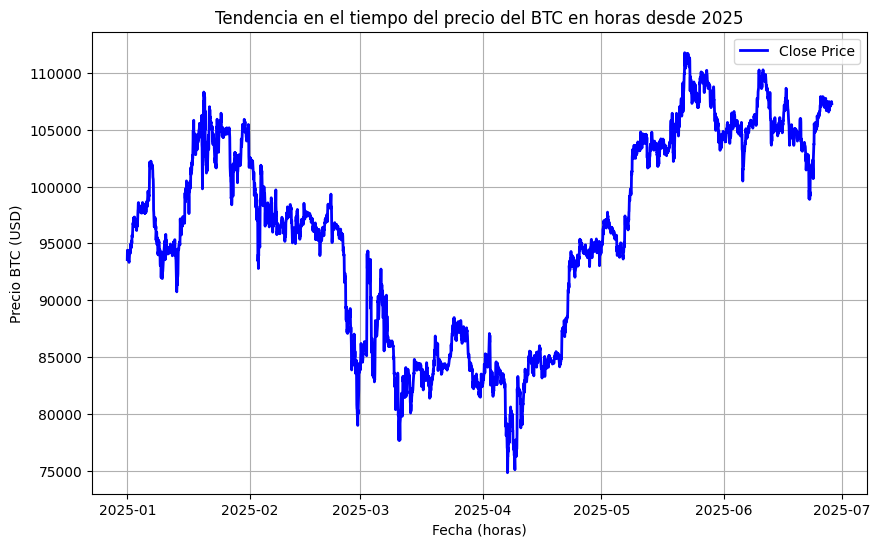

In [8]:
# Plotting
plt.figure(figsize=(10, 6))
#plt.plot(data_btc['Close'], label='Precio BTC-USD', color='blue')
plt.plot(data_BTC_hour.index, data_BTC_hour['Close'], label = 'Close Price', color = 'blue', linewidth = 2)
plt.title('Tendencia en el tiempo del precio del BTC en horas desde 2025')
plt.xlabel('Fecha (horas)')
plt.ylabel('Precio BTC (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Regresión: Predecir el valor exacto

Este modelo se usa para decir cual será su precio:

Métricas: MSE, MAE, RMSE, y se puede visualizar comparando valores predichos vs. reales.

### 🔍 Diferencias entre `model.predict()` y `model.evaluate()`

| Característica                         | `model.predict()`                                   | `model.evaluate()`                                |
|----------------------------------------|-----------------------------------------------------|---------------------------------------------------|
| ¿Devuelve predicciones reales?         | ✅ Sí (valores predichos por el modelo)             | ❌ No                                              |
| ¿Calcula métricas automáticamente?     | ❌ No (debes calcular MSE, MAE, etc. manualmente)   | ✅ Sí (usa las métricas definidas al compilar)    |
| ¿Sirve para graficar resultados?       | ✅ Sí (puedes comparar predicción vs. realidad)     | ❌ No                                              |
| ¿Usado para evaluación cuantitativa?   | 👎 Parcialmente                                     | ✅ Sí                                              |
| ¿Devuelve valores individuales?        | ✅ Sí (uno por muestra)                             | ❌ No (solo métricas agregadas)                   |

---

### 🧠 ¿Cuándo usar cada uno?

- Usa `model.predict()` cuando quieras:
  - Obtener los valores predichos.
  - Compararlos con los reales.
  - Calcular métricas personalizadas o hacer gráficos.

- Usa `model.evaluate()` cuando quieras:
  - Obtener rápidamente las métricas de evaluación globales como `loss` o `accuracy`.
  - Ver cómo rinde el modelo en test/validación según las métricas compiladas.


### Regresión: Predecir el valor exacto con datos de 1 hora

#### Paso 1: Cargar datos y procesarlos

In [9]:
# ------------------------------------------------------------
# Paso 1: Cargar datos y procesarlos
# ------------------------------------------------------------

# Copiar el DataFrame y asegurar orden cronológico
nuevo_df_regre_hour = data_BTC_hour.copy()
nuevo_df_regre_hour = nuevo_df_regre_hour.sort_index()

# Crear nuevo DataFrame con solo la columna Close y reiniciar el índice
df_model = pd.DataFrame()
# Corrección: Verificar si la columna 'Close_BTC-USD' existe antes de acceder a ella.
if 'Close_BTC-USD' in nuevo_df_regre_hour.columns:
    df_model['Close'] = nuevo_df_regre_hour['Close_BTC-USD'].values.flatten() # Aplana el array
else:
    df_model['Close'] = nuevo_df_regre_hour['Close'].values.flatten() # Aplana el array
df_model.reset_index(drop=True, inplace=True)

# Eliminar última fila (sin valor futuro)
df_model = df_model[:-1]

# Separar en features y target
X = df_model[['Close']]


#### Paso 2: Escalar los datos

In [10]:
def crear_secuencias(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


In [11]:
# Escalar datos
#scaler = MinMaxScaler()
scaler = RobustScaler() # Usamos RobustScaler
scaled_close = scaler.fit_transform(df_model[['Close']].values)


# Guardar el scaler entrenado
joblib.dump(scaler, 'scaler.pkl')

# Crear secuencias para LSTM
sequence_length = 60
X, y = crear_secuencias(scaled_close, sequence_length)


split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


#### Paso 3: Crear y entrenar el modelo LSTM

In [12]:
# ------------------------------------------------------------
# Paso 3: Crear y entrenar el modelo LSTM
# ------------------------------------------------------------
# Crear el modelo
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1))) # Aumentamos unidades
model.add(Dropout(0.3)) # Ajustamos Dropout
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1))  # Regresión: una sola salida numérica

model.summary()

# Compilar el modelo
#model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error') # Ajustamos la tasa de aprendizaje y optimizador


# Entrenar
early_stop = EarlyStopping(
    monitor='val_loss',      # Lo que se observa para detener (también puede ser 'val_accuracy')
    patience=10,            # Cuántas épocas esperar sin mejora (aumentamos paciencia)
    restore_best_weights=True # Recupera los mejores pesos
)

# Incorporamos ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


history = model.fit(
    X_train, y_train,
    epochs=100,         # Aumentamos el número de épocas
    batch_size=16,       # Ajustamos el tamaño del lote
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr]  # Aquí se usa
)

C:\Users\jorge\anaconda3\envs\TFE\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,857 (1.26 MB)

 Trainable params: 329,857 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - loss: 0.0614 - val_loss: 0.0040 - learning_rate: 5.0000e-04
Epoch 2/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - loss: 0.0107 - val_loss: 0.0225 - learning_rate: 5.0000e-04
Epoch 3/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - loss: 0.0103 - val_loss: 0.0225 - learning_rate: 5.0000e-04
Epoch 4/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - loss: 0.0088 - val_loss: 0.0022 - learning_rate: 5.0000e-04
Epoch 5/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - loss: 0.0086 - val_loss: 0.0063 - learning_rate: 5.0000e-04
Epoch 6/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - loss: 0.0079 - val_loss: 0.0082 - learning_rate: 5.0000e-04
Epoch 7/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - loss: 0.0080 - val_loss: 0.0035 - learning_rate: 5.0000e-04
Epoch 8/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - loss: 0.0069 - val_loss: 0.0045 - learning_rate: 5.0000e-04
Epoch 9/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step 

#### Paso 4: Guardar el modelo entrenado

In [13]:
# ------------------------------------------------------------
# Paso 4: Guardar el modelo entrenado
# ------------------------------------------------------------

# Guardar el modelo
model.save('modelo_btc_lstm_.h5')
print("Modelo guardado como 'modelo_btc_lstm.h5'")

# Cargar el modelo entrenado
#modelo_cargado = load_model('modelo_btc_lstm.h5')

Modelo guardado como 'modelo_btc_lstm_v2.h5'


#### Paso 5: Evaluar en el conjunto de test

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0022    

Pérdida en test: 0.0018



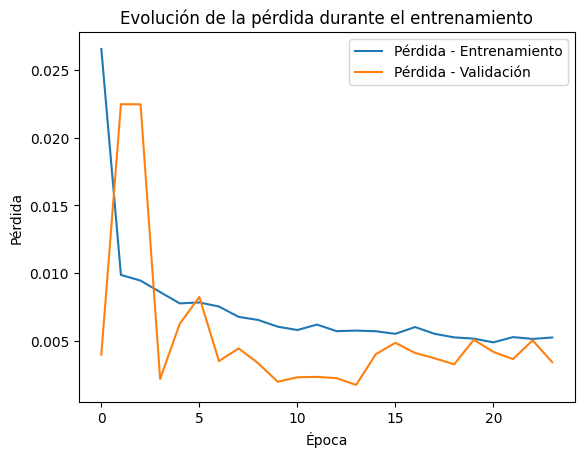

In [14]:
# ------------------------------------------------------------
# Paso 5: Evaluar en el conjunto de test
# ------------------------------------------------------------

loss = model.evaluate(X_test, y_test)
print(f"\nPérdida en test: {loss:.4f}\n")

plt.plot(history.history['loss'], label='Pérdida - Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida - Validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


#### Paso 6: Predecir y evaluar el modelo

In [15]:
# ------------------------------------------------------------
# Paso 6: Predecir y evaluar el modelo
# ------------------------------------------------------------

# Predecir en el conjunto de test
y_pred = model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred.reshape(-1)) / y_test)) * 100

print(f"\nMSE (Error cuadrático medio): {mse:.4f}")
print(f"MAE (Error absoluto medio): {mae:.4f}")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step 

MSE (Error cuadrático medio): 0.0018
MAE (Error absoluto medio): 0.0324
RMSE (Raíz del error cuadrático medio): 0.0420
MAPE: 22.74%


#### Paso 7: Comparativa entre datos reales y predicciones

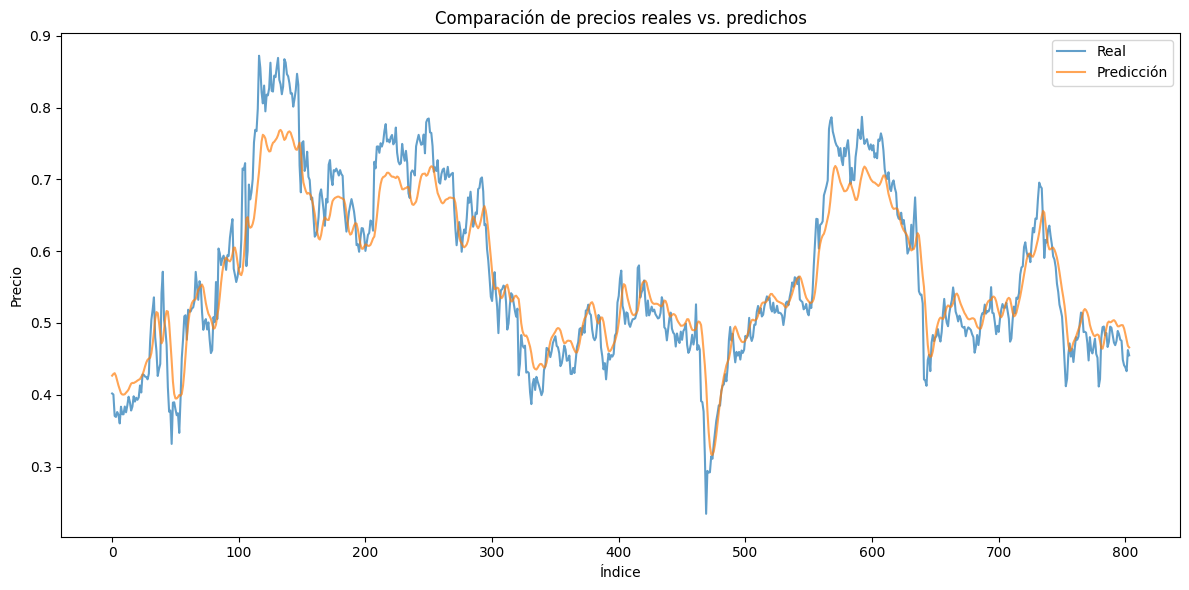

In [16]:
# ------------------------------------------------------------
# Paso 7: Comparativa entre datos reales y predicciones
# ------------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Real', alpha=0.7)
plt.plot(y_pred, label='Predicción', alpha=0.7)
plt.title('Comparación de precios reales vs. predichos')
plt.xlabel('Índice')
plt.ylabel('Precio')
plt.legend()
plt.tight_layout()
plt.show()


#### Paso 8: Predicción futura

In [17]:
# ------------------------------------------------------------
# Paso 8: Predicción futura
# ------------------------------------------------------------

# Usar las últimas 60 velas ya escaladas
ultimos_60 = scaled_close[-60:]
X_input = ultimos_60.reshape(1, 60, 1)
prediccion = model.predict(X_input)
precio = scaler.inverse_transform(prediccion)[0][0]
print(f"Predicción del próximo precio: {precio:.2f} USD")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicción del próximo precio: 104606.27 USD


In [18]:

# Base: últimos 60 pasos reales ya escalados
input_seq = list(scaled_close[-60:])
predicciones_futuras = []

for _ in range(10):
    X_input = np.array(input_seq[-60:]).reshape(1, 60, 1)
    pred = model.predict(X_input, verbose=0)[0][0]
    predicciones_futuras.append(scaler.inverse_transform([[pred]])[0][0])  # volver a escala real
    input_seq.append([pred])  # alimentar predicción como si fuera valor real siguiente

# Mostrar resultados
print("📈 Predicciones futuras:")
for i, precio in enumerate(predicciones_futuras, 1):
    print(f"Paso +{i}: {precio:.2f} USD")


📈 Predicciones futuras:
Paso +1: 104606.27 USD
Paso +2: 104681.04 USD
Paso +3: 104786.40 USD
Paso +4: 104904.76 USD
Paso +5: 105025.74 USD
Paso +6: 105144.03 USD
Paso +7: 105256.97 USD
Paso +8: 105363.24 USD
Paso +9: 105462.17 USD
Paso +10: 105553.47 USD
